## Lab Scenario
The SECNAV’s Strategic Initiative Group (SIG) chief (3-star) took much interest in your recent AIS analysis work (i.e. Lab1). The SIG is currently leading a new effort to better understand global maritime traffic patterns and reached out to the staff data scientist (i.e. You) for help. Specifically, the SIG wants to determine if certain ‘open-source’ data can serve as a potential proxy for characterizing maritime participatorial behavior of particular countries/territories, especially entities classified under a Flag of Convenience (FOC). Given that more than 80% of the world’s goods are transported by sea, it is essential to constantly improve our global maritime situational awareness and ensure global trade routes are protected and transparent.

## Tasks

#### Task 1: Inventory and Identify Files (10 points)
Determine the explicit file ‘type’ for the codes, source and tracker files. You will report the individual magic number for these three unknown files in the form of a Hex signature as well as the applicable file extension.

#### Task 2: Extract and Enrich (10 points)
Extract the ISO-3 code from the codes file for each country/territory listed in the primary_data.csv file and enrich the primary_data file by adding a new ISO-3 column.

#### Task 3: Scrape and Enrich: ITU Maritime Identification Digits (15 points)
Identify enriching each country listed in the primary_data.csv file with an associated MID as an essential task.

#### Task 4: Scrape and Enrich: Your Decision (15 points)
Seek out an additional data source to scrape and enrich the primary_data.csv file with a new column field.

#### Task 5: Flag of Convenience Analysis (40 points)
For this task, you will acquire AIS data (see Lab1) for the following range of dates: 1-3 NOV 2018. You will limit your analysis effort to the top 5 FOC countries/territories: Panama, Marshall Islands, Liberia, Hong Kong and Singapore. Your goal is to create an activity and vessel ratio.

The activity_ratio will capture the total number of AIS pings for a given Top-5 FOC country within the captured AIS data date range and divide it by that country’s merchant_vessel_count field provided in the primary_data.csv file.

The vessel_ratio will identify the total unique vessel count for a given Top-5 FOC country producing AIS pings within the captured AIS data date range and divide it by that country’s merchant_vessel_count field provided in the primary_data.csv file.

## Tutorial

#### Task 1

As this type of exchange will most assuredly occur in the near future, the `bash` method `xxd` allows a user to identify what type of file it is using its Hex signature.  The following [link](https://en.wikipedia.org/wiki/List_of_file_signatures) provides a reference to the various Hex signatures currently available.  The command `|` redirects  a program's output as input to another program and `head -1` looks at only the first entry.


-  `xxd codes | head -1`
-  `xxd source | head -1`
-  `xxd tracker | head -1`

-  The magic number for 'codes' is 3c3f 786d 6c20, which is .XML.
-  The magic number for 'source' is 2550 4446 2d, which is .PDF.
-  The magic number for 'tracker' is D0CF 11E0 A1B1 1AE1, which can be a doc, xls, ppt, or msg.

#### Task 2

Now that we've determined what the file types are, we need to begin the data import and merging operations.  Below are the libraries that we need to execute this notebook.

In [1]:
import pandas as pd
import xml.etree.ElementTree as ET
import requests
from bs4 import BeautifulSoup
import re
from fuzzywuzzy import fuzz
from fuzzywuzzy import process
import numpy as np 
import matplotlib.pyplot as plt  

# Code sourced from: https://stackoverflow.com/questions/43102734/format-a-number-with-commas-to-separate-thousands-in-python
pd.options.display.float_format = '{:,.2f}'.format

C:\Users\david\anaconda3\lib\site-packages\fuzzywuzzy\fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


We will first read in the `XML` file to create a list of lists that contains the various ISO-2 and ISO-3 codes for each country.  The code then creates a data frame using these columns.  See OA3801 Lab 4 for reference.  Once this is complete, we will read in our primary data source.  As we'll see in future code chunks, there are a small number of countries that will require manual manipulation to ensure a 'fuzzy merge.'

In [2]:
tree = ET.parse('codes.xml')
root = tree.getroot()

iso_3166_list = [] # Empty list for storage
for child in root: # Iterates over the length of the XML document
    # Appends the country name, ISO-2, and ISO-3 codes as a list to the iso_3166_list, which creates a list of lists
    iso_3166_list.append([child.attrib['alpha-2'], child.attrib['alpha-3']])
    
iso_3166_df = pd.DataFrame(iso_3166_list) # Creates a DataFrame with the iso_3166_list
iso_3166_df.columns = ['iso_2', 'iso3'] # Creates country names

ships_df = pd.read_csv('primary_data.csv') #Reads in the CSV

# We want to keep all info, even if the row doesn't have a matching key in the opposite frame
ships_df = pd.merge(ships_df, iso_3166_df, on = 'iso_2', how = 'left')

# Name changes for future merge operations
ships_df.iloc[176,0] = "Lao People's Democratic Republic" # Laos to Lao People's Democratic Republic 
ships_df.iloc[86,0] = 'Myanmar' # Burma to Myanmar
ships_df.iloc[4,0] = 'United States of America' # United States to United States of America

# Sort ships by country name
ships_df = ships_df.sort_values(by = 'country') 

# Update Namibia's information 
ships_df.iloc[115]['iso_2'] = 'NA'
ships_df.iloc[115]['iso_3'] = 'NAM'

# Print a copy of the data frame
ships_df

<ipython-input-2-baae1971ed23>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ships_df.iloc[115]['iso_2'] = 'NA'
<ipython-input-2-baae1971ed23>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ships_df.iloc[115]['iso_3'] = 'NAM'
C:\Users\david\anaconda3\lib\site-packages\pandas\core\indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


,country,merchant_vessel_count,iso_2,iso3
107,Albania,57,AL,ALB
80,Algeria,110,DZ,DZA
109,Angola,55,AO,AGO
170,Anguilla,1,AI,AIA
24,Antigua and Barbuda,964,AG,ATG
...,...,...,...,...
43,Vanuatu,421,VU,VUT
56,Venezuela,267,VE,VEN
12,Vietnam,1818,VN,VNM
126,Yemen,31,YE,YEM


#### Task 3

Since we're interested in applying web scraping skills to gather Maritime Identification Digits (MID), the following [link](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_html.html) provides documentation on the `pd.read_html()` method.  One important note is that the `pd.read_html()` method reads in all tables so you must select and access the appropriate one.  In this case, the link only contained one table so we can apply `table[0]` to select it.  As conducted in Task 2, we need to manipulate a select number of countries so `fuzzy_merge()` may execute successfully.

A regular expression (shortened as regex or regexp; also referred to as rational expression is a sequence of characters that define a search pattern. Usually such patterns are used by string-searching algorithms for "find" or "find and replace" operations on strings, or for input validation. It is a technique developed in theoretical computer science and formal language theory [Source](https://en.wikipedia.org/wiki/Regular_expression). 

Regular expression can be challenging to work with and often require patience.  A regular "checker" can save time and stress and should be used when building the code [link](https://regex101.com/).

In [3]:
# String designating website
url = 'https://en.wikipedia.org/wiki/Maritime_identification_digits'

# Read the table using pandas.read_html method
table = pd.read_html(url)

# Select the first table in the list
table = table[0]

# Rename the columns
table.rename(columns = {'Country': 'country'}, inplace = True)

# Name changes for future merge operations
table.iloc[58,0] = 'Curacao' # Change 'Curaçao - Netherlands' to Curacao
table.iloc[51,0] = 'Congo, Republic of the	' # Change Congo (Republic of the ) to Congo, Republic of the

# Regex to eliminate the '(Republic of ______)' from the string for merge operations
table['country'] = table['country'].str.replace(r'(\s\(.*\))', "")

# Sort ships by country name
table = table.sort_values(by = 'country') 

# Print a copy of the table
table

,country,Codes
0,Adelie Land,501
1,Afghanistan,401
2,Alaska,303
3,Albania,201
4,Algeria,605
...,...,...
232,Vietnam,574
233,Wallis and Futuna Islands,578
234,Yemen,473; 475
235,Zambia,678


Executing a merge with similar but different nouns can be difficult.  One method is to develop a regex that matches every possible instance, which can be quite tedious and time consuming as the previous code exemplified that a simple matching pattern that took a disproportionate amount of time to craft.  Another requires manual manipulation of each country.  While this is an option on smaller data sets, it is not scalable for larger data frames.

One method is to apply regex to the MID data that strips away the (...) and you're left with just countries.  The fuzzy wuzzy package straight out of the box matched all but five countries: Burma (aka Myanmar), Congo, Republic of, Curacao (due to non-English spelling),  Guam (doesn't even have a MID), Laos, and United States.  I highly recommend checking each country/name during any future use.  While the method isn't perfect, it is pretty close to a sure thing and is superior to messing around with trying to line everything up one by one.  This package may also be applied in the future to match names via various reports.  This [link](https://pypi.org/project/fuzzywuzzy/) provides a future reference.

In [4]:
# Code sourced from: https://stackoverflow.com/questions/13636848/is-it-possible-to-do-fuzzy-match-merge-with-python-pandas
def fuzzy_merge(df_1, df_2, key1, key2, threshold=90, limit=2):
    """
    :param df_1: the left table to join
    :param df_2: the right table to join
    :param key1: key column of the left table
    :param key2: key column of the right table
    :param threshold: how close the matches should be to return a match, based on Levenshtein distance
    :param limit: the amount of matches that will get returned, these are sorted high to low
    :return: dataframe with boths keys and matches
    """
    s = df_2[key2].tolist()

    m = df_1[key1].apply(lambda x: process.extract(x, s, limit=limit))    
    df_1['matches'] = m
    
    m2 = df_1['matches'].apply(lambda x: ', '.join([i[0] for i in x if i[1] >= threshold]))
    df_1['matches'] = m2

    return df_1

Now that we've acquired a rudimentary fuzzy merge technique, we can apply it using the previous function.  However, this function just displays a relative match to another country so a second merge operation is conducted followed by table manipulation.

In [5]:
# Since some countries are labelled similar but different, a 'fuzzy merge' can be executed
temp_df = fuzzy_merge(ships_df, table, 'country', 'country', 80, limit = 1)

# Now that we've got everything matched up, we can execute a standard pandas merge
task3_df = pd.merge(temp_df, table, left_on = 'matches', right_on = 'country', how = 'left')

# Since Guam doesn't have any country codes, it gets left out of the loop so we need to change it manually
task3_df.iloc[67,4] = 'Guam'

# Remove excess columns
task3_df.drop(['country_x'], axis=1, inplace=True)
task3_df.drop(['country_y'], axis=1, inplace=True)

# Rename the 'matches' column to 'country'
task3_df.rename(columns = {'matches': 'country'}, inplace = True)

# Sort the data frame by country alphabetically
task3_df.sort_values('country', inplace = True)

# Print a copy of the dataframe
task3_df

,merchant_vessel_count,iso_2,iso3,country,Codes
0,57,AL,ALB,Albania,201
1,110,DZ,DZA,Algeria,605
2,55,AO,AGO,Angola,603
3,1,AI,AIA,Anguilla,301
4,964,AG,ATG,Antigua and Barbuda,304; 305
...,...,...,...,...,...
172,421,VU,VUT,Vanuatu,576; 577
173,267,VE,VEN,Venezuela,775
174,1818,VN,VNM,Vietnam,574
175,31,YE,YEM,Yemen,473; 475


#### Task 4

For Task 4, we are required to seek out and scrape for additional data and comparative analysis to a ship's [Flag of Convenience](https://en.wikipedia.org/wiki/Flag_of_convenience).  Additional data might include the number of financial regulations (i.e. the lower the number of regulations the higher number of maritime vessels), the number of ports (i.e. the more ports the more ships can dock), or Gross Domestic Product (i.e. the higher the GDP, the more ships required to transport goods).

As a result, the link below depicts GDP per capita as well as population for every country in the world.  We will use the same code above given a URL string, `pd.read_html()`, select the first table, and conduct manual data frame manipulation for future merge operations.

In [6]:
# String designating website
url2 = 'https://worldpopulationreview.com/countries/countries-by-gdp'

# Read the table using pandas.read_html method
table2 = pd.read_html(url2)

# Select the first table in the list
table2 = table2[0]

# Name changes for future merge operations
table2.iloc[89,1] = "Côte d'Ivoire" # Ivory Coast to Côte d'Ivoire
table2.iloc[112,1] = "Lao People's Democratic Republic" # Laos to Lao People's Democratic Republic
table2.iloc[86,1] = 'Democratic Republic of the Congo' #Dr congo to Democratic Republic of the Congo

# Set index so we can drop countries that interfere with merge operations
table2.set_index('Name', inplace = True)

# Drop countries that interfere with merge operations
table2.drop(['Czech Republic', 'Mali', 'Bosnia And Herzegovina', 'South Sudan', 'Saint Lucia'], axis=0, inplace = True)

# Reset the index
table2.reset_index(inplace = True)

# Print a copy of the table
table2

,Name,Rank,GDP (IMF '19),GDP (UN '16),GDP Per Capita,2019 Population
0,United States,1,22.20 Tn,18.62 Tn,"$67,063",331002651
1,China,2,15.47 Tn,11.22 Tn,"$10,747",1439323776
2,Japan,3,5.50 Tn,4.94 Tn,"$43,450",126476461
3,Germany,4,4.16 Tn,3.48 Tn,"$49,617",83783942
4,India,5,3.26 Tn,2.26 Tn,"$2,361",1380004385
...,...,...,...,...,...,...
201,Pakistan,207,NaN,282.51 Bn,"$1,279",220892340
202,Anguilla,208,NaN,337.52 Mn,"$22,497",15003
203,Sudan,209,NaN,82.89 Bn,"$1,890",43849260
204,Syria,210,NaN,22.16 Bn,"$1,266",17500658


We can execute a similar `fuzzy_merge()` as before and then remove excess columns to create a data frame that contains maritime information for each country in our original list.

In [7]:
# Since some countries are labelled similar but different, a 'fuzzy merge' can be executed
temp_df = fuzzy_merge(table2, task3_df, 'Name', 'country', 80, limit = 1)

# Now that we've got everything matched up, we can execute a standard pandas merge
task4_df = pd.merge(temp_df, task3_df, left_on = 'matches', right_on = 'country', how = 'right')

# Remove excess columns
task4_df.drop(['matches'], axis=1, inplace=True)
task4_df.drop(['country'], axis=1, inplace=True)

# Sort the data frame by country alphabetically
task4_df.sort_values('Name', inplace = True)

# Set data frame index
task4_df.set_index('Name', inplace = True)

# Rename the columns
task4_df.rename(columns = {'Rank': 'GDP Rank'}, inplace = True)
task4_df.rename(columns = {'Codes': 'MID Codes'}, inplace = True)

#### Task 5

The `bash` command `wget`downloads files served with HTTP, HTTPS, or FTP over a network.  If `wget` is not installed in your `bash` shell, `sudo apt-get install wget` will install or update it.

`wget` uses the following format: `wget [option] [URL]`.  The method `wget` contains a multitude of options that include but not limited to: input file options, download options, and HTTP options. See the following [link](https://www.computerhope.com/unix/wget.htm) for documentation.

It is important to note that as of 17OCT20, `wget` requires the 'URL' be linked to the desired file itself.  In its present form, `wget` is unable to first go to a URL then exercise an 'option' that contains a second URL string directing you to the desired file.

An option of `wget` is to read in a text file that contains various URLs and execute each command.  In the event you need to download multiple files, copy and paste their URLs into a single .txt file.  Then use the `-i` option to read the .txt file containing the URLs.  The code I ultimately used for this task is depicted below.

-  `wget -i WGET.txt`

The `bash` command `unzip` allows a user to view and report metadata details about each daily file.  If `unzip` is not installed within your `bash` shell, `sudo apt install unzip` can be used to install the method.

The `unzip` command uses the following format `unzip <OPTIONS> [MODIFIER] <ZIPFILE> [<OPTIONS>] <FILE_or_DIRECTORY>`.  While `unzip` does not contain as many permutations of options or modifiers, `unzip` can be modified. See the following [link](hhttps://www.computerhope.com/unix/unzip.htm) for documentation.

To unzip a file, use the command below.

-  `unzip AIS_2018_11_01.zip`
-  `unzip AIS_2018_11_02.zip`
-  `unzip AIS_2018_11_03.zip`

Now that we have unzipped the files, we can see that they are rather large.  Therefore, it is incumbent upon our computer's efficiency to reduce it to a more manageable size.  Once that is complete, the three data frames can be concatenated using `pd.concat`.  Once this is complete, a new master AIS data frame of three days of AIS data is compiled chronologically.

In [8]:
vessel_data1 = pd.read_csv("AIS_2018_11_01.csv")
vessel_data1 = pd.Series(vessel_data1['MMSI'])
vessel_data1 = vessel_data1.apply(lambda _: str(_))

In [9]:
vessel_data2 = pd.read_csv("AIS_2018_11_02.csv")
vessel_data2 = pd.Series(vessel_data2['MMSI'])
vessel_data2 = vessel_data2.apply(lambda _: str(_))

In [10]:
vessel_data3 = pd.read_csv("AIS_2018_11_03.csv")
vessel_data3 = pd.Series(vessel_data3['MMSI'])
vessel_data3 = vessel_data3.apply(lambda _: str(_))

In [11]:
master_vessel_data = pd.concat([vessel_data1, vessel_data2, vessel_data3])

In [12]:
master_vessel_data

0          367005220
1          368059910
2          267181950
3          367003470
4          367689230
             ...    
7070677    311000369
7070678    563049900
7070679    563033900
7070680    367632910
7070681    338049554
Name: MMSI, Length: 21016736, dtype: object

To determine the activity and vessel ratio for each country, we may apply the following algorithm:
1. Create a particular regex string for each MID code.
2. Use `re.findall` to identify the different number MMSI codes within the master AIS data frame.    
3. Determine and aggregate the total number of pings for each MID code.
4. Determine the total number of pings for each MMSI.

In [13]:
#           Panama
# Create regex strings to search for each countries MMSI within 01-03NOV18
PAN_MMSI351 = r'^351{1}\d\d\d\d\d\d'
PAN_MMSI352 = r'^352{1}\d\d\d\d\d\d'
PAN_MMSI353 = r'^353{1}\d\d\d\d\d\d'
PAN_MMSI354 = r'^354{1}\d\d\d\d\d\d'
PAN_MMSI355 = r'^355{1}\d\d\d\d\d\d'
PAN_MMSI356 = r'^356{1}\d\d\d\d\d\d'
PAN_MMSI357 = r'^357{1}\d\d\d\d\d\d'
PAN_MMSI370 = r'^370{1}\d\d\d\d\d\d'
PAN_MMSI371 = r'^371{1}\d\d\d\d\d\d'
PAN_MMSI372 = r'^372{1}\d\d\d\d\d\d'
PAN_MMSI373 = r'^373{1}\d\d\d\d\d\d'
PAN_MMSI374 = r'^374{1}\d\d\d\d\d\d'

# Search for the different number of MMSI codes used by the country in the dataframe
PAN_MMSI_codes = re.findall(r'\d\d\d', task4_df.loc['Panama', 'MID Codes'])

# Determine the number of unique ships carrying any of the country's MMSI codes
PAN_MMSI_len = len(master_vessel_data.str.findall(PAN_MMSI351).value_counts()) + len(master_vessel_data.str.findall(PAN_MMSI352).value_counts()) + len(master_vessel_data.str.findall(PAN_MMSI353).value_counts()) + len(master_vessel_data.str.findall(PAN_MMSI354).value_counts()) + len(master_vessel_data.str.findall(PAN_MMSI355).value_counts()) + len(master_vessel_data.str.findall(PAN_MMSI356).value_counts()) + len(master_vessel_data.str.findall(PAN_MMSI357).value_counts()) + len(master_vessel_data.str.findall(PAN_MMSI370).value_counts()) +  len(master_vessel_data.str.findall(PAN_MMSI371).value_counts()) + len(master_vessel_data.str.findall(PAN_MMSI372).value_counts()) + len(master_vessel_data.str.findall(PAN_MMSI373).value_counts())

# Determine the total number of pings for each MMSI
PAN_MMSI_activity = master_vessel_data.str.contains(PAN_MMSI351).sum() + master_vessel_data.str.contains(PAN_MMSI352).sum() + master_vessel_data.str.contains(PAN_MMSI353).sum() + master_vessel_data.str.contains(PAN_MMSI354).sum() + master_vessel_data.str.contains(PAN_MMSI355).sum() + master_vessel_data.str.contains(PAN_MMSI356).sum() + master_vessel_data.str.contains(PAN_MMSI357).sum() + master_vessel_data.str.contains(PAN_MMSI370).sum() + master_vessel_data.str.contains(PAN_MMSI371).sum() + master_vessel_data.str.contains(PAN_MMSI372).sum() + master_vessel_data.str.contains(PAN_MMSI373).sum() + master_vessel_data.str.contains(PAN_MMSI374).sum()

#           Marshall Islands
# Create regex strings to search for each countries MMSI within 01-03NOV18
MAR_MMSI538 = r'^538{1}\d\d\d\d\d\d'

# Determine the number of unique ships carrying any of the country's MMSI codes
MAR_MMSI_len = len(master_vessel_data.str.findall(MAR_MMSI538).value_counts())

# Determine the total number of pings for each MMSI
MAR_MMSI_activity = master_vessel_data.str.contains(MAR_MMSI538).sum()

#           Liberia
# Create regex strings to search for each countries MMSI within 01-03NOV18
LIB_MMSI636 = r'^636{1}\d\d\d\d\d\d'
LIB_MMSI637 = r'^637{1}\d\d\d\d\d\d'

# Search for the different number of MMSI codes used by the country in the dataframe
LIB_MMSI_codes = re.findall(r'\d\d\d', task4_df.loc['Liberia', 'MID Codes'])

# Determine the number of unique ships carrying any of the country's MMSI codes
LIB_MMSI_len = len(master_vessel_data.str.findall(LIB_MMSI636).value_counts()) + len(master_vessel_data.str.findall(LIB_MMSI637).value_counts())

# Determine the total number of pings for each MMSI
LIB_MMSI_activity = master_vessel_data.str.contains(LIB_MMSI636).sum() + master_vessel_data.str.contains(LIB_MMSI637).sum()

#           Hong Kong
# Create regex strings to search for each countries MMSI within 01-03NOV18
HK_MMSI477 = r'^477{1}\d\d\d\d\d\d'

# Determine the number of unique ships carrying any of the country's MMSI codes
HK_MMSI_len = len(master_vessel_data.str.findall(HK_MMSI477).value_counts())

# Determine the total number of pings for each MMSI
HK_MMSI_activity = master_vessel_data.str.contains(HK_MMSI477).sum()

#           Singapore
# Create regex strings to search for each countries MMSI within 01-03NOV18
SIN_MMSI563 = r'^563{1}\d\d\d\d\d\d'
SIN_MMSI564 = r'^564{1}\d\d\d\d\d\d'
SIN_MMSI565 = r'^565{1}\d\d\d\d\d\d'
SIN_MMSI566 = r'^566{1}\d\d\d\d\d\d'

# Search for the different number of MMSI codes used by the country in the dataframe
SIN_MMSI_codes = re.findall(r'\d\d\d', task4_df.loc['Singapore', 'MID Codes'])

# Determine the number of unique ships carrying any of the country's MMSI codes
SIN_MMSI_len = len(master_vessel_data.str.findall(SIN_MMSI563).value_counts()) + len(master_vessel_data.str.findall(SIN_MMSI564).value_counts()) + len(master_vessel_data.str.findall(SIN_MMSI565).value_counts()) + len(master_vessel_data.str.findall(SIN_MMSI566).value_counts())

# Determine the number of unique ships carrying any of the country's MMSI codes
SIN_MMSI_activity = master_vessel_data.str.contains(SIN_MMSI563).sum() + master_vessel_data.str.contains(SIN_MMSI564).sum() + master_vessel_data.str.contains(SIN_MMSI565).sum() + master_vessel_data.str.contains(SIN_MMSI566).sum()

Once these values are determined, we may calculate the activity ratio as previously defined.

In [14]:
# Activity ratio
PAN_activity_ratio = PAN_MMSI_activity / task4_df.loc['Panama', 'merchant_vessel_count']
MAR_activity_ratio = MAR_MMSI_activity / task4_df.loc['Marshall Islands', 'merchant_vessel_count']
LIB_activity_ratio = LIB_MMSI_activity / task4_df.loc['Liberia', 'merchant_vessel_count']
HK_activity_ratio = HK_MMSI_activity / task4_df.loc['Hong Kong', 'merchant_vessel_count']
SIN_activity_ratio = SIN_MMSI_activity / task4_df.loc['Singapore', 'merchant_vessel_count']

In [15]:
print("The activity ratio for Panama is ", round(PAN_activity_ratio,2), ".", sep='')
print("The activity ratio for the Marshall Islands is ", round(MAR_activity_ratio,2), ".", sep='')
print("The activity ratio for Liberia is ", round(LIB_activity_ratio,2), ".", sep='')
print("The activity ratio for Hong King is ", round(HK_activity_ratio,2), ".", sep='')
print("The activity ratio for Singapore is ", round(SIN_activity_ratio,2), ".", sep='')

The activity ratio for Panama is 43.61.
The activity ratio for the Marshall Islands is 116.1.
The activity ratio for Liberia is 76.21.
The activity ratio for Hong King is 50.99.
The activity ratio for Singapore is 40.44.


Create a simple visualization of each country's activity ratio.

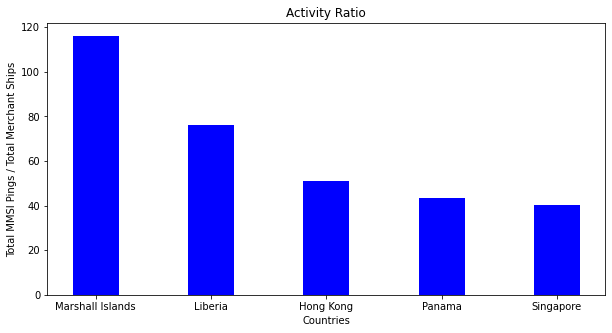

In [16]:
# creating the dataset 
activity_data = {'Marshall Islands':MAR_activity_ratio, 'Liberia':LIB_activity_ratio, 
        'Hong Kong':HK_activity_ratio,  'Panama':PAN_activity_ratio, 'Singapore': SIN_activity_ratio} 
courses = list(activity_data.keys()) 
values = list(activity_data.values()) 
   
fig = plt.figure(figsize = (10, 5)) 
  
# creating the bar plot 
plt.bar(courses, values, color ='blue',  
        width = 0.4) 
  
plt.xlabel("Countries") 
plt.ylabel("Total MMSI Pings / Total Merchant Ships") 
plt.title("Activity Ratio") 
plt.show() 

Once these values are determined, we may calculate the activity ratio as previously defined.

In [17]:
# Vessel ratio
PAN_vessel_ratio = PAN_MMSI_len / task4_df.loc['Panama', 'merchant_vessel_count']
MAR_vessel_ratio = MAR_MMSI_len / task4_df.loc['Marshall Islands', 'merchant_vessel_count']
LIB_vessel_ratio = LIB_MMSI_len / task4_df.loc['Liberia', 'merchant_vessel_count']
HK_vessel_ratio = HK_MMSI_len / task4_df.loc['Hong Kong', 'merchant_vessel_count']
SIN_vessel_ratio = SIN_MMSI_len / task4_df.loc['Singapore', 'merchant_vessel_count']

In [18]:
print("The vessel ratio for Panama is ", round(PAN_vessel_ratio,2), ".", sep='')
print("The vessel ratio for the Marshall Islands is ", round(MAR_vessel_ratio,2), ".", sep='')
print("The vessel ratio for Liberia is ", round(LIB_vessel_ratio,2), ".", sep='')
print("The vessel ratio for Hong King is ", round(HK_vessel_ratio,2), ".", sep='')
print("The vessel ratio for Singapore is ", round(SIN_vessel_ratio,2), ".", sep='')

The vessel ratio for Panama is 0.04.
The vessel ratio for the Marshall Islands is 0.12.
The vessel ratio for Liberia is 0.08.
The vessel ratio for Hong King is 0.05.
The vessel ratio for Singapore is 0.05.


Create a simple visualization of each country's activity ratio.

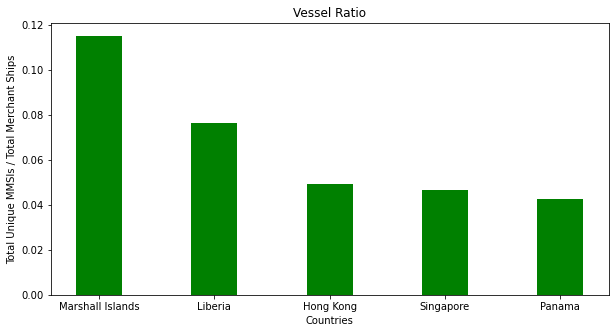

In [19]:
# creating the dataset 
vessel_data = {'Marshall Islands':MAR_vessel_ratio, 'Liberia':LIB_vessel_ratio, 
        'Hong Kong':HK_vessel_ratio, 'Singapore': SIN_vessel_ratio,   'Panama':PAN_vessel_ratio} 
courses = list(vessel_data.keys()) 
values = list(vessel_data.values()) 
   
fig = plt.figure(figsize = (10, 5)) 
  
# creating the bar plot 
plt.bar(courses, values, color ='green',  
        width = 0.4) 
  
plt.xlabel("Countries") 
plt.ylabel("Total Unique MMSIs / Total Merchant Ships") 
plt.title("Vessel Ratio") 
plt.show() 

Create a simple visualization of each country's GDP.

In [20]:
# Extract GDPs for the interested countries
MI_GDP = task4_df.loc["Marshall Islands", "GDP (IMF '19)"]
LIB_GDP = task4_df.loc["Liberia", "GDP (IMF '19)"]
HK_GDP = task4_df.loc["Hong Kong", "GDP (IMF '19)"]
SIN_GDP = task4_df.loc["Singapore", "GDP (IMF '19)"]
PAN_GDP = task4_df.loc["Panama", "GDP (IMF '19)"]

# Apply Regex and strip 'millions' from Marshall Islands then divide by 1000 to conver to Billions
MI_GDP = float(re.sub('\s\w\w', "", MI_GDP))/1000 

# Apply regex and strip billions from Singapore, Liberia, Hong Kong, and Panama
HK_GDP = float(re.sub('\s\w\w', "", HK_GDP))
SIN_GDP = float(re.sub('\s\w\w', "", SIN_GDP))
LIB_GDP = float(re.sub('\s\w\w', "", LIB_GDP))
PAN_GDP = float(re.sub('\s\w\w', "", PAN_GDP))

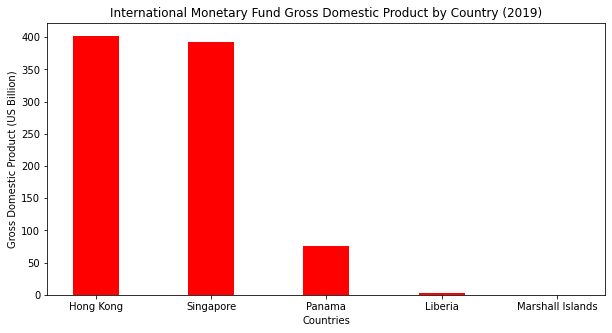

In [21]:
# creating the dataset 
GDP_data = {'Hong Kong':HK_GDP, 'Singapore': SIN_GDP, 'Panama':PAN_GDP, 'Liberia':LIB_GDP, 'Marshall Islands':MI_GDP} 
courses = list(GDP_data.keys()) 
values = list(GDP_data.values()) 
   
fig = plt.figure(figsize = (10, 5)) 
  
# creating the bar plot 
plt.bar(courses, values, color ='red',  
        width = 0.4) 
  
plt.xlabel("Countries") 
plt.ylabel("Gross Domestic Product (US Billion)") 
plt.title("International Monetary Fund Gross Domestic Product by Country (2019)") 
plt.show() 

## Analysis

#### Vessel Ratio
A given country's vessel ratio is indicative of a percentage of unique ships active during 01-03NOV18.  For example, the Marshall Islands' vessel ratio is approximately 0.12, which means 12% of its ships were active during the allotted time frame. This low percentage might be a combination of any of the following factors: merchant_vessel_count from `primary_data.csv` is outdated, countries don't update their register, or the remaining ships weren't active during these days either from maintenance or other port operations. 

#### Activity Ratio
The lab prompt states that the previous five countries are the top 5 Flag of Convenience countries.  A given country's activity ratio is indicative of the total number of MMSI pings divided by its total merchant vessel count.  It could be inferred that these five countries produce the highest number of MMSI pings and as a subsequent result, produce higher activity ratios.  For example, the Marshall Islands sends out sizably more pings than any of the other four countries in part as it had more unique ships available to ping during this time frame.  We can see from the vessel and activity bar plots that the vessel and activity ratios are correlated.  While Marshall Islands, Liberia, and Hong Kong remain as the top three countries, Singapore and Panama are reversed.  Singapore's activity ratio is lower than Panama's but its vessel ratio is higher.  This reversal may be a result of Singapore's ships pulling into port during this time period and turning off their transponder.  

#### Conclusion
Despite having a Gross Domestic Product (GDP) markedly lower than their peers as evidenced in the bar plot above, the Marshall Islands and Liberia account for the two largest vessel and activity ratios.  One can conclude that the ratios do not necessarily correlate to a higher GDP.  As a result, this gap may be a direct result of corruption within the Flag of Convenience system.  Further study of every country's merchant vessel count and their activity and vessel ratios may confirm or deny this conjecture.